### Question: Why we don't need a collate function?

Answer: The primary function of a collate function is to gather a batch of samples into organized tensors, specifically for labels, texts, and offsets. It operates by taking a list of label-text tuples and outputs a trio of tensors: one for labels, one for concatenated texts, and one for offsets to pinpoint the starting position of each text within the concatenated tensor.

However, when utilizing TF-IDF representations, where each sentence is already represented as a 5000-dimensional vector, the necessity for a collate function diminishes. This is because, with TF-IDF vectors, we bypass the need for concatenated tensors and offset values to guide the model in extracting sentence index values. The model directly leverages the TF-IDF vector representation, simplifying the data preparation process and making the collate function redundant in this context.

In [1]:
!pip install torchinfo
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 5.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import joblib
from functools import partial
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from collections import Counter
from torchtext.vocab import vocab
import torch
from torchinfo import summary
from torchmetrics import HammingDistance
import numpy as np

In [3]:
df = joblib.load('/content/drive/MyDrive/df_multilabel_hw_cleaned.joblib')
df.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [4]:
df['Tag_Number_int'] = df['Tag_Number'].apply(ast.literal_eval)
df.head()

,cleaned_text,Tags,Tag_Number,Tag_Number_int
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]","[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]","[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]","[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]","[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]","[3, 5]"


In [5]:
mlb = MultiLabelBinarizer()
one_hot_encoded_tags = mlb.fit_transform(df['Tag_Number_int']).astype(float)
print("Classes:", mlb.classes_)

Classes: [0 1 2 3 4 5 6 7 8 9]


In [6]:
one_hot_encoded_tags

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(df['cleaned_text'].values, one_hot_encoded_tags, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((28455,), (9486,), (9486,))

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)

X_train = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
X_test = tfidf.transform(X_test)

In [10]:
X_train.shape, X_val.shape, X_test.shape

((28455, 5000), (9486, 5000), (9486, 5000))

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X.toarray()
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        texts = self.X[idx]
        labels = self.y[idx]
        sample = (labels, texts)

        return sample

In [12]:
trainset = CustomDataset(X_train, y_train)
validset = CustomDataset(X_val, y_val)
testset = CustomDataset(X_test, y_test)

In [13]:
check_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=7, shuffle=True)

In [14]:
for _label, _text_tfidf in check_loader:
    print(_label.shape)
    print(_text_tfidf.shape)
    break

torch.Size([7, 10])
torch.Size([7, 5000])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()
        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim, mode='mean')
        self.fc1 = nn.Linear(embedding_dim, hidden_dim1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(drop_prob1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(drop_prob2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, input_tuple):
        indices, offsets = input_tuple
        x = self.embedding_bag(indices, offsets)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        output = self.fc3(x)

        return output

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self, tfidf_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()
        self.fc1 = nn.Linear(tfidf_dim, hidden_dim1)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(drop_prob1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.dropout2 = nn.Dropout(drop_prob2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, num_outputs)

    def forward(self, _text_tfidf):
        x = self.fc1(_text_tfidf)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.batchnorm1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.batchnorm2(x)
        output = self.fc3(x)

        return output

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleMLP(tfidf_dim=5000, hidden_dim1=200, hidden_dim2=100, drop_prob1=0.5, drop_prob2=0.5, num_outputs=10)
model = model.to(device)

data = torch.randn((2,5000)).to(device)

hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)

summary(model, input_data=[data], device=device, depth=10, verbose=False)

Layer (type:depth-idx)                   Output Shape              Param #
SimpleMLP                                [2, 10]                   --
├─Linear: 1-1                            [2, 200]                  1,000,200
├─ReLU: 1-2                              [2, 200]                  --
├─Dropout: 1-3                           [2, 200]                  --
├─BatchNorm1d: 1-4                       [2, 200]                  400
├─Linear: 1-5                            [2, 100]                  20,100
├─ReLU: 1-6                              [2, 100]                  --
├─Dropout: 1-7                           [2, 100]                  --
├─BatchNorm1d: 1-8                       [2, 100]                  200
├─Linear: 1-9                            [2, 10]                   1,010
Total params: 1,021,910
Trainable params: 1,021,910
Non-trainable params: 0
Total mult-adds (M): 2.04
Input size (MB): 0.04
Forward/backward pass size (MB): 0.01
Params size (MB): 4.09
Estimated Total Size (MB

In [18]:
output = model(data)
print(output)

tensor([[ 0.5442,  0.1042,  0.3357,  0.2407,  0.2452,  0.3049, -0.3260, -0.5184,
          0.0489,  0.0528],
        [-0.6693,  0.0769, -0.2673, -0.2363, -0.1149, -0.2976,  0.2586,  0.5137,
         -0.1048, -0.1817]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [19]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None):
    model = model.to(device)
    inputs = inputs.to(device)
    targets = targets.to(dtype=torch.float32)
    targets = targets.to(device)

    outputs = model(inputs)

    if loss_function:
        loss = loss_function(outputs, targets)

    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
        optimizer.step()

    if loss_function:
        return loss, outputs
    else:
        return None, outputs

In [20]:
def train_epoch(train_loader, model, device, loss_function, optimizer):
    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model.train()
    running_train_loss = 0.0

    for targets, inputs in train_loader:
        inputs = inputs.to(dtype=torch.float32, copy=False).to(device)
        targets = targets.to(dtype=torch.float32, copy=False).to(device)
        loss, predicted = step(inputs, targets, model, device, loss_function, optimizer)
        running_train_loss += loss.item()
        train_hamming_distance.update(predicted, targets)

    train_loss = running_train_loss / len(train_loader)
    train_hamming_distance = train_hamming_distance.compute()

    return train_loss, train_hamming_distance

In [21]:
def val_epoch(valid_loader, model, device, loss_function):
    val_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model.eval()
    running_val_loss = 0.0

    for targets, inputs in valid_loader:
        inputs = inputs.to(dtype=torch.float32, copy=False).to(device)
        targets = targets.to(dtype=torch.float32, copy=False).to(device)
        loss, predicted = step(inputs, targets, model, device, loss_function, optimizer=None)
        running_val_loss += loss.item()
        val_hamming_distance.update(predicted, targets)

    val_loss = running_val_loss / len(valid_loader)
    val_hamming_distance = val_hamming_distance.compute()

    return val_loss, val_hamming_distance

In [27]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device, patience):
    train_loss_history = []
    valid_loss_history = []
    train_hamm_history = []
    valid_hamm_history = []
    for epoch in range(epochs):
        train_loss, train_hamm = train_epoch(
            train_loader, model, device, loss_function, optimizer)


        valid_loss, valid_hamm = val_epoch(
            valid_loader, model, device, loss_function)


        train_loss_history.append(train_loss)
        train_hamm_history.append(train_hamm)
        valid_loss_history.append(valid_loss)
        valid_hamm_history.append(valid_hamm)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"Train Loss: {train_loss:.4f} | Train Hamming Loss: {train_hamm}")
        print(f"Valid Loss: {valid_loss:.4f} | Valid Hamming Loss: {valid_hamm}")
        print()

        if all(element == valid_loss_history[-1] for element in valid_loss_history[-patience:]):
          break

    return train_loss_history, train_hamm_history, valid_loss_history, valid_hamm_history

In [28]:
# model Parameters
TFIDF_MAX_FEATURES=5000
HIDDEN_DIM1=200
HIDDEN_DIM2=100
DROP_PROB1=0.5
DROP_PROB2=0.5
NUM_OUTPUTS=10
PATIENCE=5

# training
EPOCHS=5
BATCH_SIZE=128
LEARNING_RATE=0.001
WEIGHT_DECAY=0.0

In [29]:
import random
import numpy as np

SEED = 9198
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

train_loader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

loss_function = nn.BCEWithLogitsLoss()

model_facebook = SimpleMLP(tfidf_dim=TFIDF_MAX_FEATURES,
                       hidden_dim1=HIDDEN_DIM1,
                       hidden_dim2=HIDDEN_DIM2,
                       drop_prob1=DROP_PROB1,
                       drop_prob2=DROP_PROB2,
                       num_outputs=NUM_OUTPUTS)

optimizer = torch.optim.AdamW(model_facebook.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [30]:
for targets, inputs in train_loader:
    inputs = inputs.to(dtype=torch.float32, copy=False).to(device)
    targets = targets.to(dtype=torch.float32, copy=False).to(device)
    model_facebook = model_facebook.to(device)
    model_facebook.eval()

    with torch.no_grad():
        output = model_facebook(inputs)
        loss = loss_function(output, targets)
        print(f'Actual loss: {loss.item()}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.6820579767227173
Expected Theoretical loss: 0.6931471805599453


In [31]:
%%time
train_losses, train_hamm, valid_losses, valid_hamm = train(
    train_loader, valid_loader, model_facebook, optimizer, loss_function, EPOCHS, device, PATIENCE)

Epoch 1/5
Train Loss: 0.3410 | Train Hamming Loss: 0.1286557912826538
Valid Loss: 0.1430 | Valid Hamming Loss: 0.048387110233306885

Epoch 2/5
Train Loss: 0.1374 | Train Hamming Loss: 0.048023223876953125
Valid Loss: 0.1199 | Valid Hamming Loss: 0.04380136728286743

Epoch 3/5
Train Loss: 0.1077 | Train Hamming Loss: 0.03917062282562256
Valid Loss: 0.1123 | Valid Hamming Loss: 0.041471660137176514

Epoch 4/5
Train Loss: 0.0926 | Train Hamming Loss: 0.03363555669784546
Valid Loss: 0.1080 | Valid Hamming Loss: 0.03909975290298462

Epoch 5/5
Train Loss: 0.0826 | Train Hamming Loss: 0.030131757259368896
Valid Loss: 0.1071 | Valid Hamming Loss: 0.03814041614532471

CPU times: user 9.31 s, sys: 5.15 s, total: 14.5 s
Wall time: 26.6 s


In [32]:
import matplotlib.pyplot as plt
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")
    if val_losses:
        plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    if train_metrics[0] is not None:
        plt.figure()
        plt.plot(epochs, train_metrics, label="Train")
        if val_metrics:
            plt.plot(epochs, val_metrics, label="Validation")
        plt.xlabel("Epochs")
        plt.ylabel("Metric (Hamming loss)")
        plt.legend()
        plt.show()

In [34]:
train_hamm = [i.item() for i in train_hamm]
valid_hamm = [i.item() for i in valid_hamm]

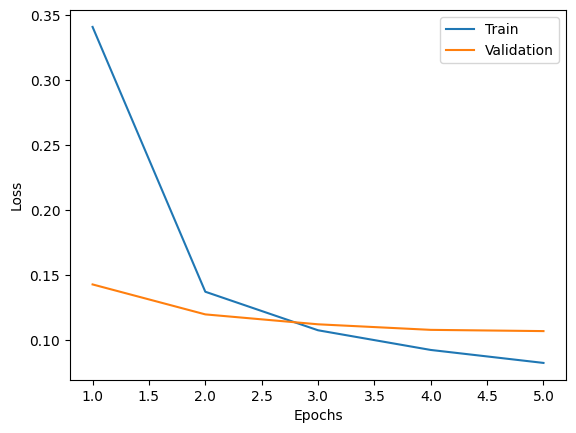

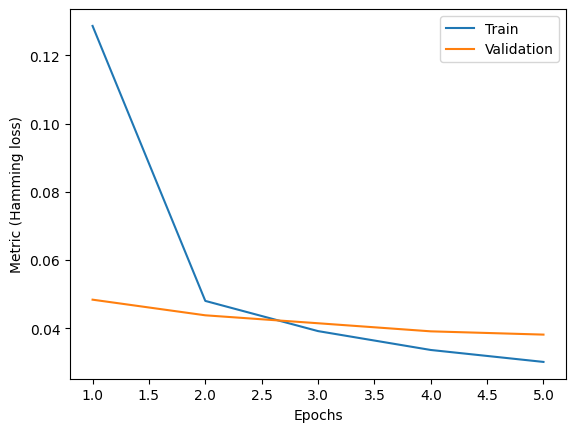

In [35]:
plot_history(train_losses, train_hamm, valid_losses, valid_hamm)

In [36]:
def get_acc_pred(data_loader, model, device):
    val_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)
    model = model.to(device)
    model.eval()

    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)
    running_correct = 0
    with torch.no_grad():
        for targets, inputs in data_loader:
            inputs = inputs.to(dtype=torch.float32, copy=False)
            targets = targets.to(device)
            _, predicted = step(inputs, targets, model,
                              device, loss_function=None, optimizer=None)

            predictions = torch.cat((predictions, predicted))
            y = torch.cat((y, targets))
            val_hamming_distance.update(predicted, targets)

    val_hamming_distance = val_hamming_distance.compute()

    return predictions, y, val_hamming_distance.item()

In [37]:
predictions_test, labels_test, hamming_distance_test = get_acc_pred(test_loader, model_facebook, device)
predictions_train, labels_train, hamming_distance_train = get_acc_pred(train_loader, model_facebook, device)
predictions_val, labels_val, hamming_distance_val = get_acc_pred(valid_loader, model_facebook, device)

In [38]:
# Print Test Accuracy
print('Test hamming distance:', hamming_distance_test)

Test hamming distance: 0.038467228412628174


In [40]:
hamming_distance_train, hamming_distance_val, hamming_distance_test

(0.015403270721435547, 0.03814041614532471, 0.038467228412628174)

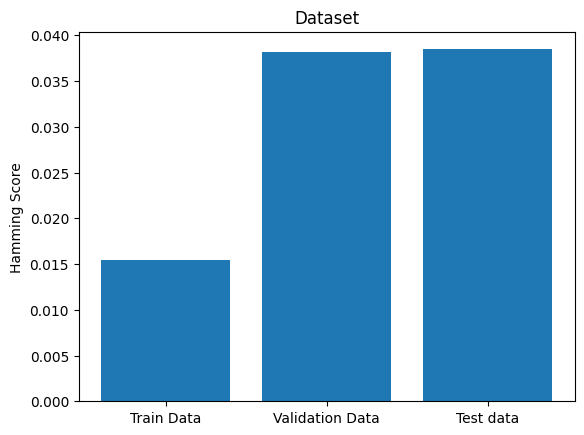

In [39]:
import matplotlib.pyplot as plt

# Scalar values
values = [hamming_distance_train, hamming_distance_val, hamming_distance_test]
labels = ['Train Data', 'Validation Data', 'Test data']

# Plotting
plt.bar(labels, values)
plt.ylabel('Hamming Score')
plt.title('Dataset')
plt.show()

The model demonstrates good generalization capabilities, as evidenced by the minimal increase in Hamming distance when moving from the training set to the validation and test sets. This minor uptick is typical when models encounter new data, indicating that the model is not overly fitted to the training data and retains its predictive accuracy on unseen data.

The similarity in Hamming distances between the validation and test sets underscores the model's consistent performance across various unseen data sets. This consistency underscores the model’s dependability and stability.

Considering the low Hamming distances observed across the board, it's evident that the model achieves a high level of accuracy in its predictions for this multi-label classification task, with incorrect predictions being as low as approximately 0.015 for the training set and around .038 and 0.038 for both the validation and test sets respectively.